In [1]:
%run ./Vlad_Dissertation.ipynb

/home/renato/.virtualenvs/pps/lib/python3.11/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
/tmp/ipykernel_44472/1247435164.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


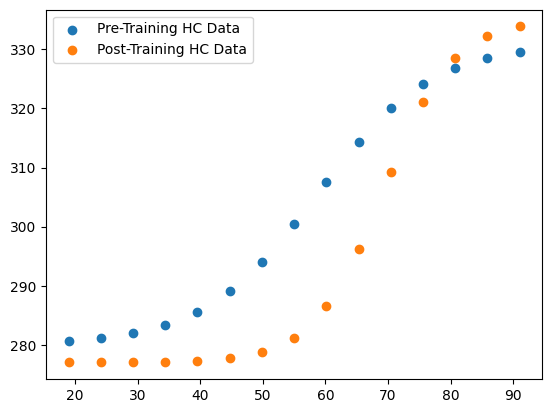

In [13]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
mydistances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###Healthy Controls
ymin = 280
ymax = 331
fprHCCP = 100 - 1.377 * v
fprHCS = 1 / 0.11  # negative

HC_RTs = RTsig(mydistances, fprHCCP, fprHCS)
plt.scatter(mydistances, HC_RTs, label="Pre-Training HC Data")

##Post-Training
###Healthy Controls
ymin = 277
ymax = 335
fpostHCCP = 100 - 1.028 * v
fpostHCS = 1 / 0.18  # negative

HC_RTs_post = RTsig(mydistances, fpostHCCP, fpostHCS)
plt.scatter(mydistances, HC_RTs_post, label="Post-Training HC Data")
plt.legend()

In [4]:
from scipy.optimize import differential_evolution

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.185e01, 7.769e02, 3.881e01, 9.517e-01
)

k_a = 5e-05
k_v = 5e-05
stim_counts = 10


def train_hcmodel(theta):
    rho_0 = theta[0]
    sigav_x = theta[1]
    locav_x = theta[2]

    HCWa_tr, HCWv_tr, _, _, _, _ = FWTraining(
        stim_counts,
        simtime,
        ts,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa,
        HCWv,
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        rho_0,
        6.5,
        6.5,
        k_a,
        k_v,
        0.05,
        sigav_x,
        locav_x,
    )

    _, _, _, _, HCrtpost = experiment(
        ts,
        simtime,
        mydistances,
        5,
        HCLt,
        HCLa,
        HCLv,
        HCWt,
        HCWa_tr[:, :, -1, -1],
        HCWv_tr[:, :, -1, -1],
        HCBt,
        HCBa,
        HCBv,
        HCWat,
        HCWvt,
        HCWav,
        0,
        0,
    )

    xf = HCrtpost
    yf = HC_RTs_post

    m = (xf.size * np.sum(xf * yf) - np.sum(xf) * np.sum(yf)) / (
        xf.size * np.sum(xf * xf) - np.sum(xf) ** 2
    )
    bias = (np.sum(yf) - m * np.sum(xf)) / xf.size

    if bias < 0:
        bias = 0
    if m < 0:
        m = 0

    cost = np.sum(np.square(np.divide(yf - (m * xf + bias), yf)))

    return cost * 100000


bounds = [(0, 0.1), (0.01, 9), (38, 100)]
train_hcmodel_res = differential_evolution(
    train_hcmodel, bounds, disp=True, workers=-1, updating="deferred", polish=False
)

differential_evolution step 1: f(x)= 128.77265811028835
differential_evolution step 2: f(x)= 101.2754414194254
differential_evolution step 3: f(x)= 37.26965246744135
differential_evolution step 4: f(x)= 35.22729261456698
differential_evolution step 5: f(x)= 32.104785492180845
differential_evolution step 6: f(x)= 32.104785492180845
differential_evolution step 7: f(x)= 32.104785492180845
differential_evolution step 8: f(x)= 32.104785492180845
differential_evolution step 9: f(x)= 32.104785492180845
differential_evolution step 10: f(x)= 32.104785492180845
differential_evolution step 11: f(x)= 32.104785492180845
differential_evolution step 12: f(x)= 32.104785492180845
differential_evolution step 13: f(x)= 32.104785492180845
differential_evolution step 14: f(x)= 32.104785492180845
differential_evolution step 15: f(x)= 32.104785492180845
differential_evolution step 16: f(x)= 32.104785492180845
differential_evolution step 17: f(x)= 32.104785492180845
differential_evolution step 18: f(x)= 28.27

In [5]:
print(train_hcmodel_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 25.65591935120869
                   x: [ 2.005e-03  5.041e+00  4.895e+01]
                 nit: 73
                nfev: 3330
          population: [[ 2.005e-03  5.041e+00  4.895e+01]
                       [ 2.158e-03  4.979e+00  4.901e+01]
                       ...
                       [ 2.138e-03  4.972e+00  4.903e+01]
                       [ 2.062e-03  4.890e+00  4.923e+01]]
 population_energies: [ 2.566e+01  2.566e+01 ...  2.566e+01  2.566e+01]


In [10]:
## Fitted model

rho_0, siagav_x, locav_x = (
    2.005e-03,
    5.041e00,
    4.895e01,
)  # 1.633e-02, 9.858e-01 #6.222e-07

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.185e01, 7.769e02, 3.881e01, 9.517e-01
)

HCWa_tr, HCWv_tr, _, _, _, _ = FWTraining(
    stim_counts,
    simtime,
    ts,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    rho_0,
    6.5,
    6.5,
    k_a,
    k_v,
    0.05,
    siagav_x,
    locav_x,
)


_, _, _, _, HC_Model_RTs_post = experiment(
    ts,
    simtime,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa_tr[:, :, -1, -1],
    HCWv_tr[:, :, -1, -1],
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

HC_Model_RTs_post = fit_RT(HC_Model_RTs_post, HC_RTs_post)

In [16]:
_, _, _, _, HC_Model_RTs_pre = experiment(
    ts,
    simtime,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

HC_RTs_model_pre = fit_RT(HC_Model_RTs_pre, HC_RTs)

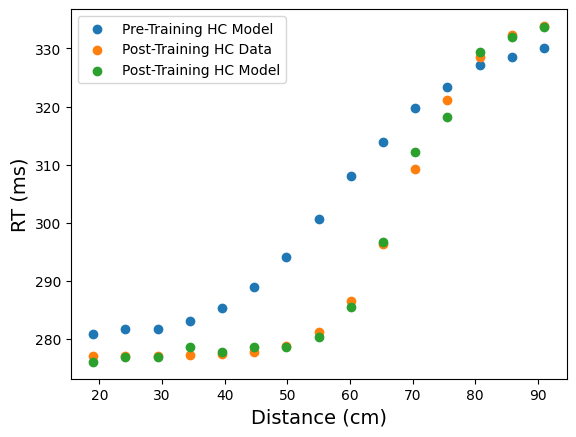

In [18]:
plt.scatter(mydistances, HC_RTs_model_pre, label="Pre-Training HC Model")
plt.scatter(mydistances, HC_RTs_post, label="Post-Training HC Data")
plt.scatter(mydistances, HC_Model_RTs_post, label="Post-Training HC Model")
plt.ylabel("RT (ms)", size=14)
plt.xlabel("Distance (cm)", size=14)
plt.legend(prop={"size": 12})
plt.legend()